Cumulateive distribution function (CDF):

$F_X(x)=Pr(X\leq x)$

Pecentile point function (PPF):

$Q_X(p)=\inf\{x\in R:Pr(X\leq x)\geq p \}$

$Q_X(p)=\inf\{x\in R:F_X(x)\geq p \}$

Trivially we have, $Q_X(F_X(x))=x$

Consider

$\phi(p) =F_{X+Y}(Q_X(p)+Q_Y(p))-p$

In [1]:
# import util
from pymisc.util import *
# import vis_util 
from pymisc.vis_util import *


is in ipython: 1
[WARN] pymisc.vis_util cannot find network


CPU times: user 308 ms, sys: 8 ms, total: 316 ms
Wall time: 305 ms


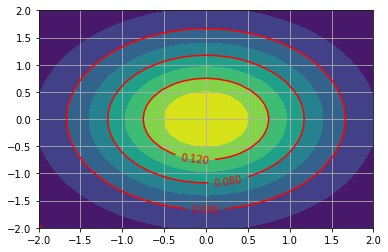

CPU times: user 1.38 s, sys: 60 ms, total: 1.44 s
Wall time: 1.36 s


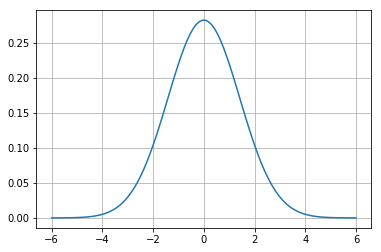

In [23]:
import scipy.stats as spstat
import scipy.integrate as spint
   
def joint_p(p1,p2,log=0):
    '''
    Calculate joint dist P(X,Y)=P(X)*P(Y)
    '''
    if log:
        def jpdf(x1,x2):
            val = p1.logpdf(x1) + p2.logpdf(x2)
            return val
    else:
        def jpdf(x1=None,x2=None):
            val = p1.pdf(x1) * p2.pdf(x2)
            return val
    return jpdf

def make_spdf(p1,p2,epsrel=1E-4,epsabs=0.0001,
             cutoff=1E-5):
    '''
    Calculate PDF for the distribution of sum: P(X+Y=x)
    '''
    jpdf = joint_p(p1,p2)

    lo = p2.ppf(cutoff)
    hi = p2.ppf(1-cutoff)
    def spdf(s):
        f = lambda x1:jpdf(x1,s-x1)
        return spint.quad(f,lo,hi,
                          epsabs=epsabs,epsrel=epsrel)[0]
    return np.vectorize(spdf)
    
def make_scdf(p1,p2,cutoff=1E-3,num=100,nCPU = 1):
    '''
    Calculate CDF for the sum (P(X+Y<=x) )
    '''
    spdf = make_spdf(p1,p2,cutoff=cutoff)
    rg = map(lambda p:p1.ppf(p)+p2.ppf(p),[cutoff,1-cutoff])
    xs = np.linspace(*rg,num=num)
#     ys = mp_map(spdf,xs)
    ys = spdf(xs)
    ys = np.cumsum(ys)*(xs[1]-xs[0])
    xs = (xs[1:]+xs[:-1])/2.
    ys = ys[:-1]
    scdf = functools.partial(np.interp,xp=xs,fp=ys)
    return scdf
def make_sppf(p1,p2,*args):
    '''wrapper function'''
    scdf = make_scdf(p1,p2,*args)
    return invert_interp(scdf)
# jpdf = joint_p(p1,p2)
if __name__=='__main__':
    p1 =spstat.norm(loc=0,scale=1)
    p2 =spstat.norm(loc=0,scale=1)


    jpdf = joint_p(p1,p2)
    %time dmet_2d(jpdf);
    plt.show()

    spdf = make_spdf(p1,p2)
    %time preview(spdf,rg=[-6,6])
    plt.show()
# spint.dblquad()
# spint.dblquad( jpdf, -4, 4, , lambda _:4, args=(), epsabs=1.49e-08, epsrel=1.49e-08)

In [12]:
def main(p1,p2,cutoff=1E-3,num=100):
    '''
    Plotting utility
    '''
    scdf = make_scdf(p1,p2,cutoff=cutoff,num=num)
    Gp = lambda p: scdf(p1.ppf(p)+p2.ppf(p))-p
    
    fig,axs = plt.subplots(1,3,figsize=[12,4])
    
    plt.sca(axs[0])
    preview(p1.ppf,label='X')
    preview(p2.ppf,label='Y')
    plt.title('PPF for X and Y')
    plt.grid()
    plt.legend()
    
    plt.sca(axs[1])
    preview(scdf,rg=map(invert_interp(scdf),[0.001,0.999]) )
    plt.title('CDF for X+Y')
    
    plt.sca(axs[2])
    preview(Gp)
    plt.hlines(xmin=0,xmax=1,y=0,linestyles='--')
    plt.plot(0.5,Gp(0.5),'x')
    plt.title('G(p)\n'+'G(0.5)=%.3E'%(Gp(0.5)))
    print 'Gp(0.5)=',Gp(0.5)
    
    plt.show()

Gp(0.5)= -9.99805771507e-09


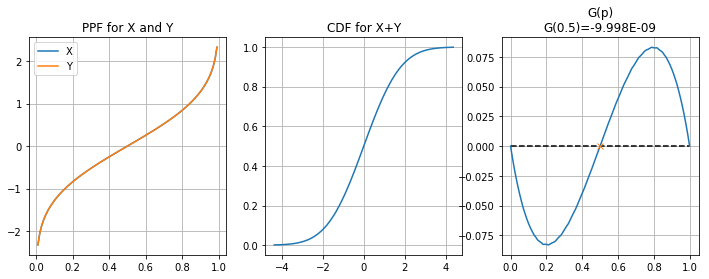

In [31]:
p1 =spstat.norm(loc=0,scale=1)
p2 =spstat.norm(loc=0,scale=1)
main(p1,p2,cutoff=1E-8)

Gp(0.5)= 1.08469788707e-10


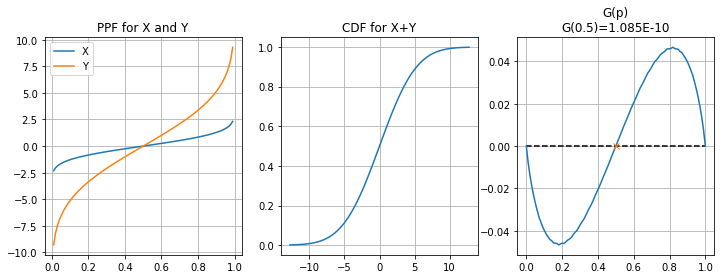

In [32]:
p1 =spstat.norm(loc=0,scale=1)
p2 =spstat.norm(loc=0,scale=4)
main(p1,p2,cutoff=1E-8)

Gp(0.5)= -0.0441127582065


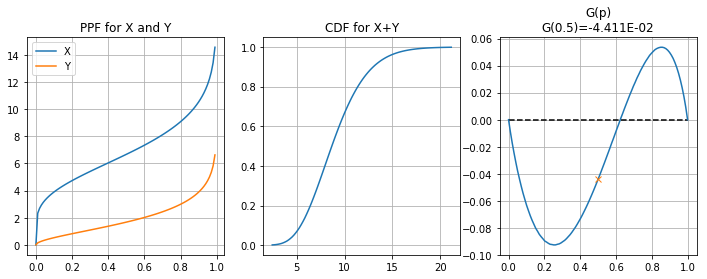

In [35]:
p1 =spstat.gamma(loc=0, a= 7)
p2 =spstat.gamma(loc=0, a= 2)
main(p1,p2,cutoff=1E-8,num=200)

Gp(0.5)= -0.0449959094244


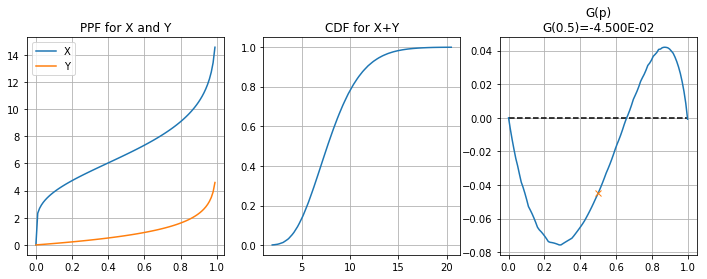

In [26]:
p1 =spstat.gamma(loc=0, a= 7)
p2 =spstat.gamma(loc=0, a= 1)
main(p1,p2,cutoff=1E-8)

Gp(0.5)= -0.0278876370345


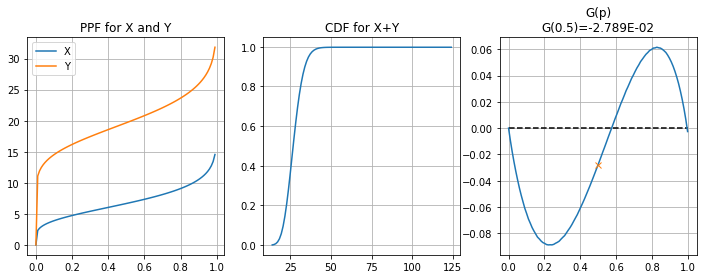

In [42]:
p1 =spstat.gamma(loc=0, a= 7)
p2 =spstat.gamma(loc=0, a= 20)
main(p1,p2,cutoff=1E-14,num=200)

Gp(0.5)= -0.0719301390836


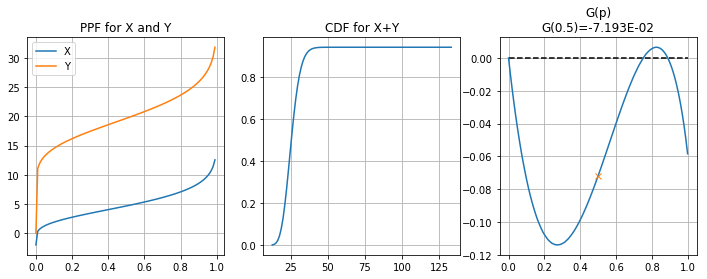

In [63]:
p1 =spstat.gamma(loc=-2, a= 7)
p2 =spstat.gamma(loc=0, a= 20)
main(p1,p2,cutoff=1E-16,num=400)

Gp(0.5)= -0.375934066203


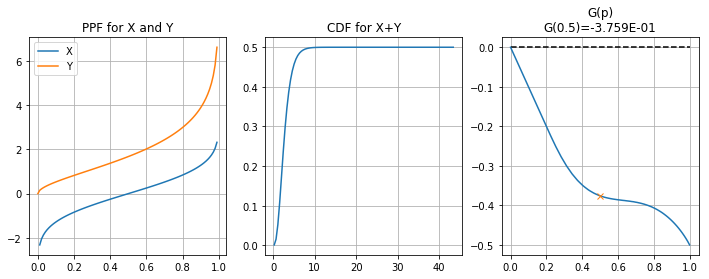

In [43]:
p1 =spstat.norm(loc=0,scale=1)
p2 =spstat.gamma(loc=0, a= 2)
main(p1,p2,cutoff=1E-14,num=300)